# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [ ]:
%tensorflow_version 1.x
#!pip install Keras==2.0.8

TensorFlow 1.x selected.


In [ ]:
#%rm -rf /content/Data-Scince-Project/
!git clone https://github.com/matterport/Mask_RCNN.git
!git clone https://github.com/Malik-Abdulaziz-Akbar/Data-Scince-Project.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
Cloning into 'Data-Scince-Project'...
remote: Enumerating objects: 4414, done.
remote: Counting objects: 100% (4414/4414), done.
remote: Compressing objects: 100% (2276/2276), done.
remote: Total 4414 (delta 2166), reused 4362 (delta 2136), pack-reused 0
Receiving objects: 100% (4414/4414), 52.80 MiB | 37.06 MiB/s, done.
Resolving deltas: 100% (2166/2166), done.


In [ ]:
import os
os.chdir('/content/Mask_RCNN/samples')

In [ ]:

import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
import sys
import math
from numpy import zeros
from numpy import asarray
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
from os import listdir
from xml.etree import ElementTree
import numpy as np
import skimage.io
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
import mrcnn
from mrcnn import utils
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [ ]:

#inherting  from Config class

class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 5+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    # Learning rate
    #LEARNING_RATE=0.01
    
    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    #MAX_GT_INSTANCES=10

In [ ]:
config= myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
class NIC_Dataset(Dataset):
    # load the dataset definitions
    def load_dataset(self,  is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "fname")
        self.add_class("dataset", 2, "lname")
        self.add_class("dataset", 3, "country")
        self.add_class("dataset", 4, "id")
        self.add_class("dataset", 5, "dob")
        
        # define data locations for images and annotations
        IMAGES_DIR = '/content/Data-Scince-Project/Augmented Dataset1/'

        ANNOTATIONS_DIR = '/content/Data-Scince-Project/Augmented Annotations1/'
        

        i = 0
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(IMAGES_DIR):
            i = i+1
            # extract image id
            image_id = filename[:-4]
            
            # # skip bad images
            # if image_id in ['00090']:
            #     continue
            # skip all images after 150 if we are building the train set
            if is_train and i >= 70:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and i < 70:
                continue
            
            # setting image file
            img_path = IMAGES_DIR + filename
            
            # setting annotations file
            ann_path = ANNOTATIONS_DIR + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)


            
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
        
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        list_of_classes = ['fname','lname','country','id','dob']
        j = 0
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(list_of_classes[j]))
            j = j+1
        return masks, asarray(class_ids, dtype='int32')
# load an image reference
     
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [ ]:
# prepare train set
train_set = NIC_Dataset()
train_set.load_dataset( is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = NIC_Dataset()
test_set.load_dataset( is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 69
Test: 14


In [ ]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Loading Mask R-CNN model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
#load the weights for COCO
model.load_weights(COCO_MODEL_PATH, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
## train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads')
history = model.keras_model.history.history

In [ ]:
model.keras_model.get_weights()


[array([[[[ 2.69967280e-02, -1.03560323e-02, -9.61696170e-03, ...,
            1.44892037e-02,  2.73446124e-02, -1.62345711e-02],
          [ 5.08543998e-02,  1.34496149e-02, -1.08427759e-02, ...,
            3.90880462e-03,  1.40184417e-01, -3.92733747e-03],
          [ 2.89727189e-02, -4.61213570e-03, -1.59294046e-02, ...,
            3.88147961e-03, -9.74359140e-02, -2.48403177e-02]],
 
         [[ 3.54219414e-02, -2.20392589e-02, -9.27638635e-03, ...,
           -3.44394408e-02, -1.82512291e-02, -2.77525373e-02],
          [ 2.25274134e-02, -6.20388286e-03, -7.39856437e-03, ...,
           -2.50900090e-02,  6.40571043e-02, -3.23415287e-02],
          [ 3.50016020e-02, -1.34674730e-02, -5.47591550e-03, ...,
           -2.53922231e-02, -1.15436902e-02, -4.69023399e-02]],
 
         [[ 3.20640542e-02, -7.33477436e-03, -8.40825611e-04, ...,
           -1.32111302e-02, -1.18067442e-02, -6.36814833e-02],
          [ 2.45266547e-03,  5.26396744e-03,  1.53420446e-03, ...,
            2.853

In [ ]:
import time
model_path = '/content/mask_rcnn_'  + '.' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)
img = load_img("/content/Data-Scince-Project/Augmented Dataset1/cnic1.jpg")
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])
print(result)

[{'rois': array([[507, 550, 573, 736],
       [106, 104, 129, 163],
       [490, 290, 561, 512],
       [122, 112, 153, 155],
       [ 95, 137, 117, 216],
       [164, 113, 209, 204]], dtype=int32), 'class_ids': array([5, 3, 4, 3, 1, 4], dtype=int32), 'scores': array([0.99267536, 0.98706806, 0.98381436, 0.8622259 , 0.8353409 ,
       0.81039727], dtype=float32), 'masks': array([[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, Fal

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
image_meta               shape: (18,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (5,)                  min:    1.00000  max:    5.00000  int32
gt_bbox                  shape: (5, 4)                min:  256.00000  max:  795.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  uint8


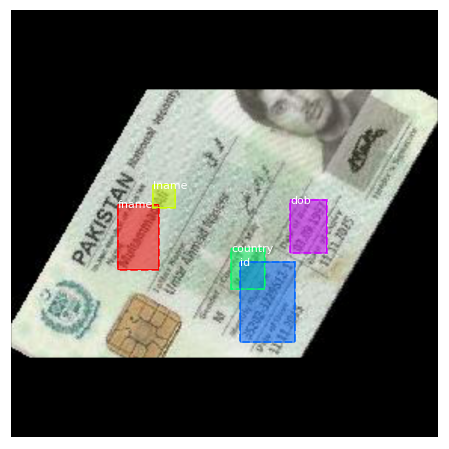

In [ ]:
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


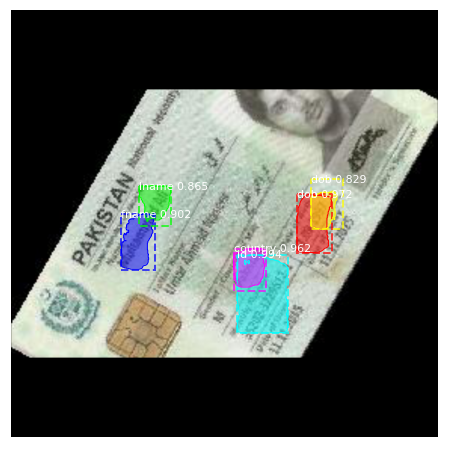

In [ ]:
import matplotlib.pyplot as plt

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=get_ax())

In [ ]:
print(history)

{'val_loss': [1.9782913327217102, 1.7399485540390014, 1.8131162381172181, 1.7539328789711, 1.6659294581413269, 1.6212837481498719, 1.5321889090538026, 1.5977585637569427, 1.6040484452247619, 1.5518025827407838, 1.6329881501197816, 1.6293071556091308, 1.7142023599147798, 1.6395977067947387, 1.6638452529907226, 1.7689397192001344, 1.8673148894309997, 1.8647119212150574, 1.8242209088802337, 1.7069783556461333], 'val_rpn_class_loss': [0.13333076000213623, 0.1079124353080988, 0.11482642693445086, 0.10418178064748645, 0.09508513284847141, 0.07925658211112023, 0.07988762916065753, 0.08715064140968025, 0.07884021061472594, 0.08208114758133889, 0.08467191103380173, 0.08188523193472065, 0.09110463618300856, 0.10282713884254918, 0.1064022558927536, 0.08918218094389886, 0.09966196167981252, 0.10228652693331242, 0.10746242531458847, 0.09476516873110086], 'val_rpn_bbox_loss': [0.410795783996582, 0.36950220704078673, 0.3732300934195518, 0.3997222843766213, 0.3795278173685074, 0.38030354350805284, 0.3